# Population Estimates: Process existing Cloud Factory annotations

We submitted ~700 tiles for CF to review prior to performing the population estimates. These tiles covered the same geographic areas for 2016, 2018 and 2020, and were sampled via random sampling stratified at the CBG-level. For this reason, although a CBG may not have been fully reviewed by CF, we assume that the 1 or 2 tiles reviewed for the CBG are representative of the small building density (number of small buildings per parcel) for the CBG. 

In [1]:
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

tqdm.pandas()

In [2]:
# Import functions
%run inference-functions.ipynb import load_data, get_bounds, assign_cbgs, visualize_tile_predvOSM, assign_cbgs_by_coverage
%run ADU_permit_matching-polygon-pipeline.ipynb import load_sources

In [3]:
# Paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
SHAPEFILE_FP = '/oak/stanford/groups/deho/building_compliance/shapefiles'
INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'inputs')
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'outputs')
PERMIT_INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Permit-Matching', 'inputs')

# Load sources for each year
TIF_FP, INFERENCES_DIR, IMG_FP = load_sources()
tile_bounds_dict_all, tiles_gdf = get_tile_dicts_all_years(oak_fp=OAK_FP, inferences_dir=INFERENCES_DIR)

# * Universe of SJ res parcels assigned to each CBG
sj_parcels_cbgs = gpd.read_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))

# * CF annotations
CF_LABELS = pd.read_csv(os.path.join(OAK_FP, 'CloudFactory_phase1/cf_coords.csv'))

# * Income-stratified CBGs (from Pop-Estimates-Strata.ipynb)
cbg_income_2016_SJ = gpd.read_file(os.path.join(OUTPUT_FP, 'Strata', 'cbg-income-strata'))

# * San Jose permit data
permits = pd.read_csv(os.path.join(OAK_FP, 'outputs/Permit-Matching/outputs/all_permits.csv'))
permits['geometry_permit'] = gpd.GeoSeries.from_wkt(permits['geometry_permit'])

# * Building footprints (to correct CF labels on tile edges)
#building_footprints_infer = {}
#for year in ['2016', '2018', '2020']:
#    building_footprints_infer[year] = gpd.read_file(
#        os.path.join(OAK_FP, 'outputs/cbg-inference-{}/inference_building_processed'.format(year)))

100%|██████████| 3324/3324 [00:00<00:00, 7431.70it/s]


## 1. Identify the universe of parcels annotated by CF

CF_parcels contains the 18k parcels that were reviewed by Cloud Factory in 2016, 2018 and 2020. 

In [4]:
# Convert to GDF
CF_LABELS = gpd.GeoDataFrame(
    CF_LABELS, geometry=gpd.points_from_xy(CF_LABELS.longitude, CF_LABELS.latitude), crs='EPSG:4326')

In [5]:
# Collect tile names
CF_tiles = []
for cf_round in [1, 2]:
    round_path = os.path.join(
        OAK_FP, 'outputs/Temporal-Error-Analysis/Round{}/CF_Visualizations/2018'.format(cf_round))
    round_tiles = glob.glob(os.path.join(round_path, '*.png'))
    round_tiles = [tile.split(os.path.sep)[-1].replace('-small_2018.png', '') for tile in round_tiles]
    CF_tiles.extend(round_tiles)

In [6]:
# Collect tile geometries
CF_area_coverage = tiles_gdf['2020'].copy()
CF_area_coverage = CF_area_coverage.loc[CF_area_coverage['file'].isin(CF_tiles)]
CF_area_coverage.to_file(os.path.join(OUTPUT_FP, 'R0_CF_Annotations', 'CF_area_coverage'))

In [7]:
# Collect associated parcels
CF_parcels = sj_parcels_cbgs.sjoin(CF_area_coverage, how='left', predicate='intersects')
CF_parcels = CF_parcels.loc[~CF_parcels['index_right'].isna()]
CF_parcels.drop('index_right', axis=1, inplace=True)

# Drop duplicate parcels (these are caused by parcels that belong to more than 1 tile)
CF_parcels.drop_duplicates('APN', inplace=True)
CF_parcels.drop('file', axis=1, inplace=True)

In [8]:
# CF annotated 17,973 (16,771 after residential and area filtering) unique parcels
# in total, for three years
len(CF_parcels)

16771

In [9]:
# Get neighborhood shapefiles
neighborhoods = cbg_income_2016_SJ.dissolve('neighborho').reset_index()
neighborhoods = neighborhoods[['neighborho', 'geometry']]

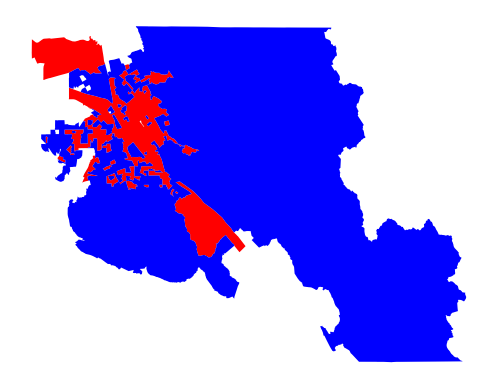

In [10]:
# Visualize neighborhoods
fig, ax = plt.subplots()
neighborhoods.loc[neighborhoods['neighborho'] == 'low'].plot(ax=ax, color='red')
neighborhoods.loc[neighborhoods['neighborho'] == 'high'].plot(ax=ax, color='blue')
ax.axis('off')
plt.show()

In [10]:
# Add neighborhood to CF_parcels
CF_parcels = pd.merge(
    CF_parcels, cbg_income_2016_SJ[['GEOID', 'neighborho']], how='left', validate='many_to_one'
)

In [11]:
# Number of parcels reviewed in each neighborhood type
# CF annotations have higher parcels in low-income neighborhood
CF_parcels.groupby('neighborho')['APN'].count().reset_index()

,neighborho,APN
0,high,8059
1,low,8712


## 2. Remove CF annotations allowing for large buildings on tile edges
We remove annotations classified as model_found_building that are actually large buildings in our building footprints. 

This strategy doesn't seem to work too well--picks up on some large buildings but several small buildings as well (perhaps due to mistakes in model inferences?) and fails to drop most large buildings, especially in earlier years. 

In [12]:
# For this universe of parcels, CF annotated 8,943 points related to potential
# small buildings (across all three yearss). Potential because large buildings 
# on tile edges were classified
# by CF as "mode_found_building" so as to not penalize model performance for this 
# tile clipping effect.
CF_LABELS.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8943 entries, 0 to 8942
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   latitude   8943 non-null   float64 
 1   longitude  8943 non-null   float64 
 2   year       8943 non-null   int64   
 3   label      8943 non-null   object  
 4   geometry   8943 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 349.5+ KB


In [15]:
# Get large buildings for each year
#large_bfi = gpd.GeoDataFrame()
#for year, gdf in building_footprints_infer.items():
#    gdf['year'] = year
#    large_bfi = pd.concat([large_bfi, gdf])
#large_bfi = large_bfi.loc[large_bfi['small'] == 0]

In [16]:
# Remove CF Labels of type "model_found_building" that reside on large buildings
#CF_LABELS_p1 = CF_LABELS.loc[CF_LABELS['label'] != 'model_found_building'].copy()
#CF_LABELS_p2 = CF_LABELS.loc[CF_LABELS['label'] == 'model_found_building'].copy()

In [19]:
#CF_LABELS_p2_corrected = gpd.GeoDataFrame()
#for year in ['2016', '2018', '2020']:
#    print('[INFO] Year: {}'.format(year))
#    cf_labels_year = CF_LABELS_p2.loc[CF_LABELS_p2['year'] == int(year)].copy()
#    large_bfi_year = large_bfi.loc[large_bfi['year'] == year].copy()
    
#    # Check for overlap with large buildings
#    n_labels = len(cf_labels_year)
#    print('[INFO] Number of labels: {}'.format(n_labels))
#    cf_labels_year = cf_labels_year.sjoin(
#        large_bfi_year[['geometry']], how='left', predicate='intersects')
    
#    assert len(cf_labels_year) == n_labels
    
    # Keep annotations that do not overlap with a large building
#    a = cf_labels_year.loc[~cf_labels_year['index_right'].isna()]
#    cf_labels_year = cf_labels_year.loc[cf_labels_year['index_right'].isna()]

#    print('[INFO] Number of labels after dropping large buildings: {}'.format(len(cf_labels_year)))
    
    # Append to corrected dataframe
#    CF_LABELS_p2_corrected = pd.concat([CF_LABELS_p2_corrected, cf_labels_year])

[INFO] Year: 2020
[INFO] Number of labels: 2222
[INFO] Number of labels after dropping large buildings: 2152


In [22]:
#a

,latitude,longitude,year,label,geometry,index_right
119,37.346789,-121.874526,2020,model_found_building,POINT (-121.87453 37.34679),202299.0
140,37.207648,-121.830395,2020,model_found_building,POINT (-121.83040 37.20765),142993.0
591,37.306186,-121.897636,2020,model_found_building,POINT (-121.89764 37.30619),88691.0
726,37.298945,-121.884426,2020,model_found_building,POINT (-121.88443 37.29895),40765.0
1207,37.319417,-121.884598,2020,model_found_building,POINT (-121.88460 37.31942),159794.0
...,...,...,...,...,...,...
8760,37.307936,-121.908437,2020,model_found_building,POINT (-121.90844 37.30794),89626.0
8772,37.307948,-121.908565,2020,model_found_building,POINT (-121.90857 37.30795),89626.0
8794,37.307954,-121.905180,2020,model_found_building,POINT (-121.90518 37.30795),89512.0
8796,37.308852,-121.905167,2020,model_found_building,POINT (-121.90517 37.30885),89455.0


In [22]:
# Concatenate with other two labels 
#CF_LABELS = pd.concat([CF_LABELS_p1, CF_LABELS_p2_corrected[CF_LABELS_p1.columns]])

In [35]:
CF_LABELS.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8943 entries, 0 to 8942
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   latitude   8943 non-null   float64 
 1   longitude  8943 non-null   float64 
 2   year       8943 non-null   int64   
 3   label      8943 non-null   object  
 4   geometry   8943 non-null   geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 349.5+ KB


In [15]:
# CF number of small buildings found in each year
CF_LABELS.groupby('year').count().reset_index()

,year,latitude,longitude,label,geometry
0,2016,2869,2869,2869,2869
1,2018,2228,2228,2228,2228
2,2020,3846,3846,3846,3846


## 3. Compute parcel-level and CBG-level measures

### 3.1 Small building density

In [12]:
cbg_density = pd.DataFrame()
parcel_density = pd.DataFrame()
for year in ['2016', '2018', '2020']:
    parcel_density_year = CF_parcels.copy()
    cf_labels_year = CF_LABELS.loc[CF_LABELS['year'] == int(year)]
    
    # Assign CF points to parcels
    parcel_density_year = parcel_density_year.sjoin(cf_labels_year, how='left')
    
    # Parcel density
    parcel_density_year = parcel_density_year.groupby(
        ['APN', 'GEOID'])['index_right'].count().reset_index()
    parcel_density_year['year'] = year
    
    # Aggregate at the CBG level (gives the mean density of the parcels reviewed by CF in a CBG)
    cbg_density_year = parcel_density_year.groupby('GEOID').agg(
        {'index_right': ['mean', 'std', 'count']}).reset_index()
    cbg_density_year.columns = ['-'.join(l) if l[1] != '' else l[0] for l in cbg_density_year.columns]
    
    cbg_density_year.rename(columns={'index_right-mean': 'mean_density', 
                                     'index_right-std': 'std_density', 
                                    'index_right-count': 'N_parcels_sampled'}, inplace=True)
    cbg_density_year['year'] = year
    
    # Append
    cbg_density = pd.concat([cbg_density, cbg_density_year])
    
    parcel_density_year.rename(columns={'index_right': 'parcel_density'}, inplace=True)
    parcel_density = pd.concat([parcel_density, parcel_density_year])

In [13]:
# Add neighborhood type
cbg_density = pd.merge(
    cbg_density, cbg_income_2016_SJ[['GEOID', 'neighborho', 'geometry']], how='left', 
    validate='many_to_one')

parcel_density = pd.merge(
    parcel_density, cbg_income_2016_SJ[['GEOID', 'neighborho']], how='left', validate='many_to_one'
)

In [90]:
# Save
parcel_density.to_csv(os.path.join(OUTPUT_FP, 'R0_CF_Annotations', 'parcel_density.csv'), index=False)

cbg_density['GEOID'] = cbg_density['GEOID'].astype(str)
cbg_density[['GEOID', 'mean_density', 'std_density', 'N_parcels_sampled', 'year', 'neighborho']].to_csv(
    os.path.join(OUTPUT_FP, 'R0_CF_Annotations', 'cbg_density.csv'), index=False)

The total growth in small buildings in this area per CF annotations is 963 added small buildings from 2016 to 2020, 362 in high income neighborhoods and 601 in low income neighborhoods.

In [26]:
# Parcel-level small building stats
a = parcel_density.groupby(['year', 'neighborho'])['parcel_density'].sum().reset_index()
a.pivot(index='neighborho', columns='year').reset_index()

neighborho parcel_density            
year                      2016  2018  2020
0          high           1161   812  1523
1           low           1664  1383  2265

### 3.2 Small building growth
Note: We assume there are no small building demolitions. I.e., we simply have to check whether small buildings in 2020 existed in 2016. 

In [14]:
parcel_growth_path = os.path.join(OUTPUT_FP, 'R0_CF_Annotations', 'parcel_growth.csv')
if not os.path.exists(parcel_growth_path):
    parcel_growth = pd.DataFrame()
    reviewed_parcels = []
else:
    parcel_growth = pd.read_csv(parcel_growth_path)
    reviewed_parcels = parcel_growth['APN'].unique()

print('[INFO] Number of reviewed parcels: {}'.format(len(reviewed_parcels)))
    
for i, apn in tqdm(enumerate(CF_parcels['APN'].unique())):
    if apn in reviewed_parcels:
        continue
    
    # Get annotations within the parcel
    CF_parcel = CF_parcels.loc[CF_parcels['APN'] == apn].copy()
    
    CF_parcel_labels = CF_LABELS.sjoin(CF_parcel, how='left', predicate='intersects').copy()
    CF_parcel_labels = CF_parcel_labels.loc[~CF_parcel_labels['index_right'].isna()]
    CF_parcel_labels = CF_parcel_labels.loc[CF_parcel_labels['year'] != 2018]
    CF_parcel_labels.drop('index_right', axis=1, inplace=True)
    
    # Edge cases: no buildings in 2020, or no buildings in 2016
    if 2020 not in CF_parcel_labels['year'].unique():
        parcel_new_build = pd.DataFrame.from_dict({'APN': [apn], 'new_small_build': [0]})
    
    if 2016 not in CF_parcel_labels['year'].unique():
        # Compute number of new small buildings and append
        parcel_new_build = pd.DataFrame.from_dict(
            {'APN': [apn], 'new_small_build': [len(CF_parcel_labels)]})
        
    if 2020 in CF_parcel_labels['year'].unique() and 2016 in CF_parcel_labels['year'].unique():
        # Check if the 2020 and 2016 buildings overlap
        parcel_2016 = CF_parcel_labels.loc[CF_parcel_labels['year'] == 2016].copy()
        parcel_2020 = CF_parcel_labels.loc[CF_parcel_labels['year'] == 2020].copy()
        parcel_2020.reset_index(inplace=True, drop=True)
        n_2020_builds = len(parcel_2020)

        parcel_2020.geometry = parcel_2020.to_crs('EPSG:26910').buffer(2).to_crs('EPSG:4326')
        parcel_2020 = parcel_2020.sjoin(parcel_2016[['geometry']], how='left', predicate='intersects')
        parcel_2020 = parcel_2020.reset_index().drop_duplicates(subset='index')

        assert len(parcel_2020) <= n_2020_builds
        parcel_new_build = pd.DataFrame.from_dict(
                {'APN': [apn], 'new_small_build': [len(parcel_2020)]})
    
    parcel_growth = pd.concat([parcel_growth, parcel_new_build])
    
    if i % 50 == 0 or i == len(CF_parcels['APN'].unique()):
        parcel_growth.to_csv(parcel_growth_path, index=False)

[INFO] Number of reviewed parcels: 16771


16771it [00:12, 1312.40it/s]


In [15]:
parcel_growth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16771 entries, 0 to 16770
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   APN              16771 non-null  object
 1   new_small_build  16771 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 262.2+ KB


## 4. Power Analysis inputs

### 4.1 Neyman allocation and parcel confidences for CF parcels

In [73]:
parcel_conf_df = pd.read_csv(
    os.path.join(OUTPUT_FP, 'Confidences', 'parcel-confidence.csv'), 
    dtype={'GEOID': str})    
parcel_conf_df = parcel_conf_df.loc[parcel_conf_df['APN'].isin(CF_parcels['APN'].unique())]

In [74]:
# Check that all are included
finalized = parcel_conf_df['APN'].unique()
x = CF_parcels['APN'].isin(finalized)
print('[INFO]: {} parcels / {} parcels'.format(x.sum(), len(CF_parcels['APN'].unique())))

[INFO]: 16770 parcels / 16771 parcels


In [76]:
# Add high/low neighborhood (defined by 75 percentile)
cbg_income_2016_SJ['quartile'] = pd.qcut(
    cbg_income_2016_SJ['median_inc'], q=4, 
    labels=['IS_{}'.format(i) for i in range(4)])

parcel_conf_df = pd.merge(
    parcel_conf_df, cbg_income_2016_SJ[['GEOID', 'quartile']], how='left', 
    validate='many_to_one')

parcel_conf_df['neighborhood(75)'] = parcel_conf_df['quartile'].apply(
    lambda q: 'High' if int(q.split('IS_')[1]) == 3 else 'Low')

In [78]:
# Generate income-confidence bins: we cut parcel confidences into low confidence (< 0.5) and
# high confidence (> 0.5)
parcel_conf_df['CBin'] = pd.cut(parcel_conf_df['confidence'], bins=2, labels=False)
parcel_conf_df['CBin'] = parcel_conf_df['CBin'].fillna(value= 'None')

parcel_conf_df['Bin'] = parcel_conf_df.apply(
    lambda row: '{}-{}'.format(row['strata_inc'], row['CBin']), axis=1)

In [79]:
# Add Y_ij: note we compute this as the average density across years as the parcel level
# given that we sample parcels, not parcel-years.
Y_ij = parcel_density.groupby('APN')['parcel_density'].mean().reset_index()
parcel_conf_df = pd.merge(parcel_conf_df, Y_ij, how='left', validate='one_to_one')

In [80]:
# Add parcel new small buildings
# Computation #1 (using parcel-level computations)
sb_growth = parcel_density.copy()
sb_growth = sb_growth.loc[sb_growth['year'] != '2018']
sb_growth = sb_growth.pivot(
    index=['APN', 'GEOID'], columns='year', values='parcel_density').reset_index()

sb_growth['num_new_sbs'] = sb_growth.apply(
    lambda row: max(0, row['2020'] - row['2016']), axis=1)
sb_growth.rename(columns={'num_new_sbs': 'new_small_build_C1'}, inplace=True)

parcel_conf_df = pd.merge(
    parcel_conf_df, sb_growth[['APN', 'new_small_build_C1']], how='left', validate='one_to_one')

# Computation #2 (using building-level computations)
parcel_conf_df = pd.merge(
    parcel_conf_df, parcel_growth[['APN', 'new_small_build']], how='left', validate='one_to_one')
parcel_conf_df.rename(columns={'new_small_build': 'new_small_build_C2'}, inplace=True)

In [81]:
parcel_conf_df.head()

,APN,confidence,GEOID,strata_inc,quartile,neighborhood(75),CBin,Bin,parcel_density,new_small_build_C1,new_small_build_C2
0,58112007,NaN,060855119051,IS_40,IS_3,High,None,IS_40-None,0.000000,0,0
1,58110066,NaN,060855119051,IS_40,IS_3,High,None,IS_40-None,0.000000,0,0
2,58115010,NaN,060855119051,IS_40,IS_3,High,None,IS_40-None,0.000000,0,0
3,58110003,NaN,060855119051,IS_40,IS_3,High,None,IS_40-None,0.000000,0,0
4,48632016,NaN,060855035063,IS_12,IS_0,Low,None,IS_12-None,0.333333,1,1


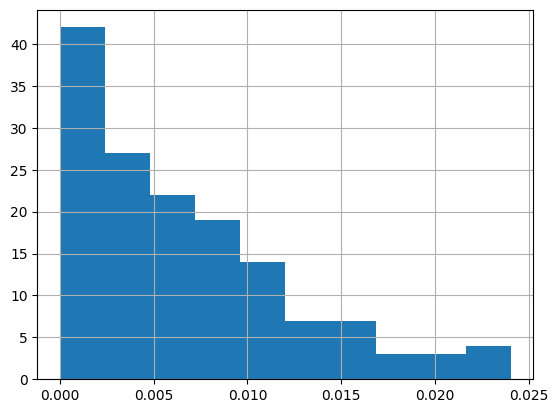

In [82]:
# Find S_j, N_j
Neyman_alloc = parcel_conf_df.groupby('Bin').agg({'APN': 'count', 'parcel_density': 'std'}).reset_index()
Neyman_alloc.rename(columns={'APN': 'N_j', 'parcel_density': 'S_j'}, inplace=True)
Neyman_denom = (Neyman_alloc['N_j'] * Neyman_alloc['S_j']).sum()
Neyman_alloc['weight'] = Neyman_alloc.apply(
    lambda row: row['N_j'] * row['S_j'] / Neyman_denom, axis=1)

Neyman_alloc['weight'].hist()
plt.show()

assert Neyman_alloc['weight'].sum() == 1

In [83]:
# Save
Neyman_alloc.to_csv(os.path.join(OUTPUT_FP, 'R0_CF_Annotations', 'PA-neyman_alloc.csv'), index=False)
parcel_conf_df.to_csv(os.path.join(OUTPUT_FP, 'R0_CF_Annotations', 'PA-CFparcels.csv'), index=False)

### 4.2 Aggregates for first power analysis (two-sample t-test of low vs high income small density)
Need to aggregate from the parcel level because we wish to compute the number of *parcels* that need to be reviewed.

In [128]:
aggregates_from_parcel = parcel_density.groupby(['year', 'neighborho']).agg(
    {'parcel_density': ['mean', 'std', 'count']}).reset_index()
aggregates_from_parcel.columns = ['-'.join(l) for l in aggregates_from_parcel.columns]

In [129]:
aggregates_from_parcel

,year-,neighborho-,parcel_density-mean,parcel_density-std,parcel_density-count
0,2016,high,0.130801,0.361301,8318
1,2016,low,0.177642,0.427024,9491
2,2018,high,0.090887,0.303736,8318
3,2018,low,0.148351,0.393188,9491
4,2020,high,0.173960,0.434654,8318
5,2020,low,0.242229,0.496576,9491


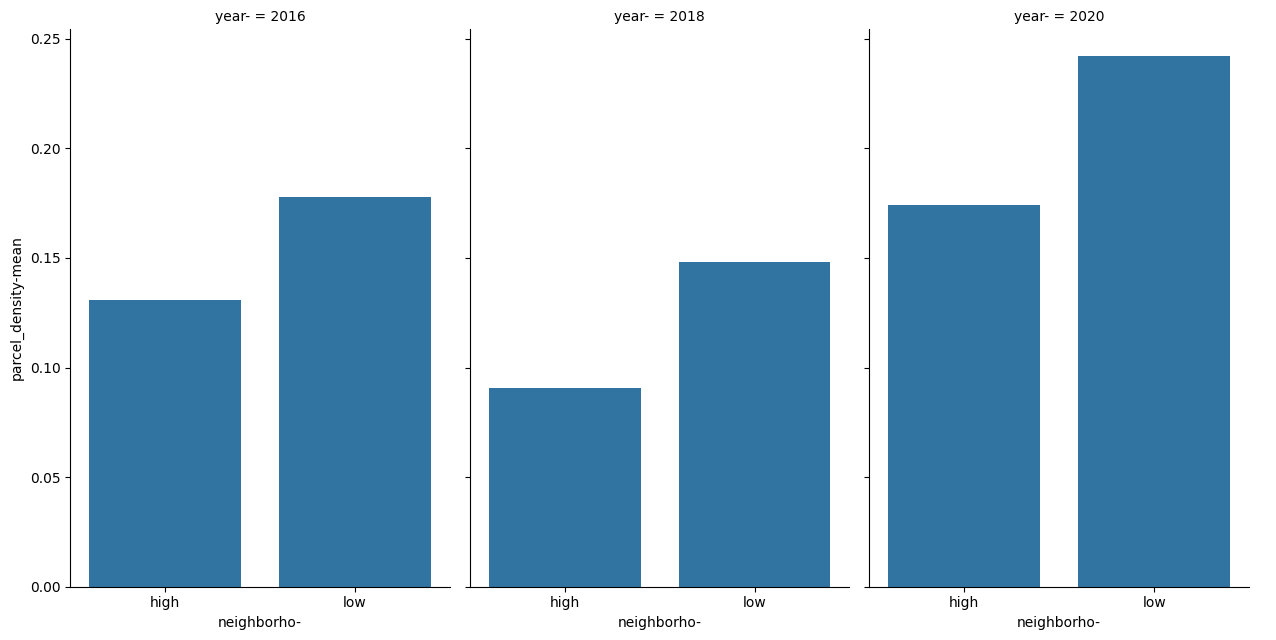

In [80]:
g = sns.FacetGrid(aggregates_from_parcel, col="year-",  height=6.5, aspect=.65)
g.map(sns.barplot, 'neighborho-', 'parcel_density-mean')
g.add_legend()
plt.show()

### 4.3 S_j

In [184]:
cbg_density.loc[cbg_density['year'] == '2020'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249 entries, 498 to 746
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   GEOID         249 non-null    object  
 1   mean_density  249 non-null    float64 
 2   std_density   241 non-null    float64 
 3   year          249 non-null    object  
 4   neighborho    245 non-null    object  
 5   geometry      249 non-null    geometry
dtypes: float64(2), geometry(1), object(3)
memory usage: 13.6+ KB


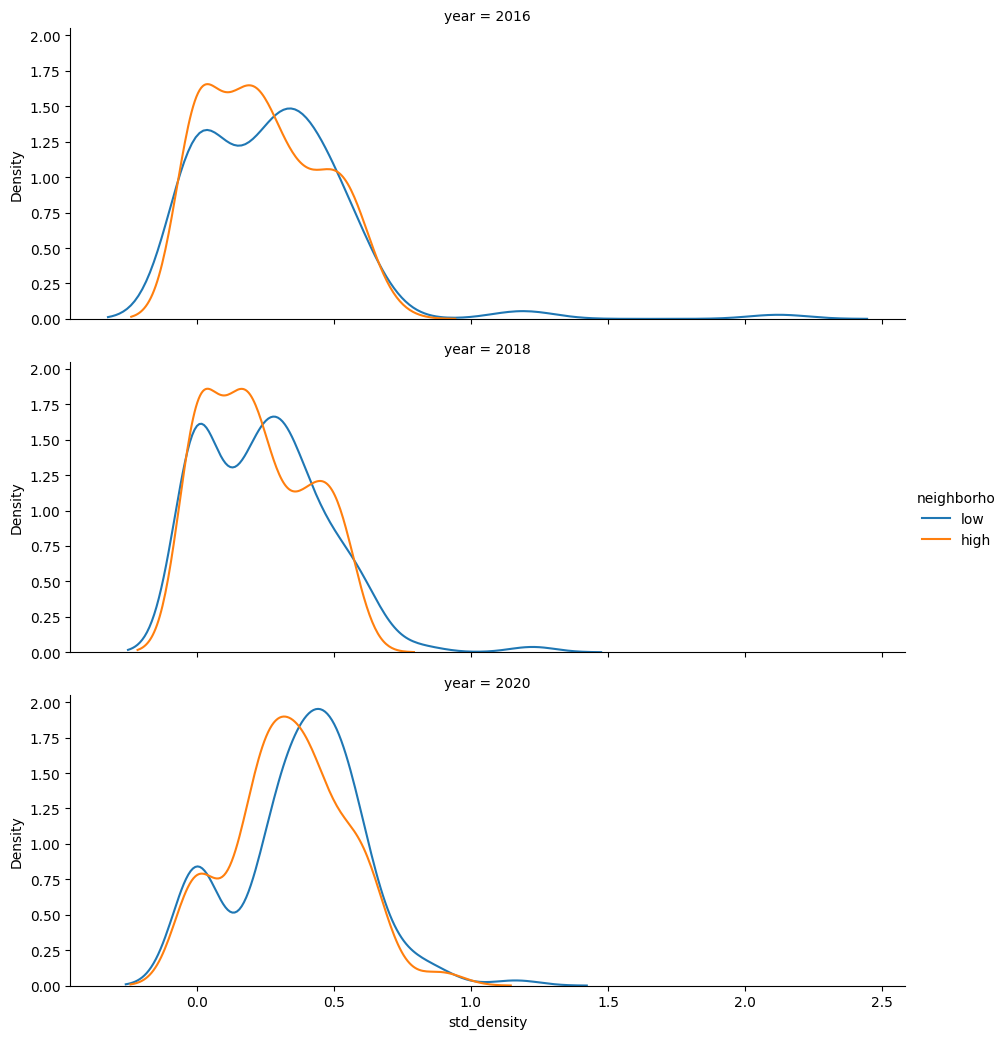

In [156]:
g = sns.FacetGrid(cbg_density, row="year", hue='neighborho', height=3.5, aspect=2.65)
g.map(sns.kdeplot, 'std_density')
g.add_legend()
plt.show()